# Tutorial 15: Data Handling in PyG (Part 2)

## Custom PyG dataset

In the first part of the notebook we will see how to create a custom dataset in PyG. 

The dataset we'll load is called FRANKENSTEIN, the files can be downloaded from the 
[networkrepository](http://networkrepository.com/FRANKENSTEIN.php) site. The dataset was originally presented in the paper titled [Graph Invariant Kernels](https://www.ijcai.org/Proceedings/15/Papers/528.pdf).

The dataset is a collection of graphs representing molecules, but the atom symbols of the vertices are substituted with MNIST digits. Each graph is associated with a label, indicating the mutagenicity of the molecule.

The following is the README of the dataset:

>FRANKENSTEIN contains the following comma separated text files:
>
>n: total number of nodes
>m: total number of edges
>N: number of graphs
>
>
>*.node_attrs (n lines) 
	matrix of node attributes,
	the comma seperated values in the i-th line is the attribute vector of the node with node_id i
>
>*.edges (m lines) 
	sparse (block diagonal) adjacency matrix for all graphs,
	each line corresponds to (row, col) resp. (node_id, node_id)
>
>*.graph_labels (N lines)
	class labels for all graphs in the dataset,
	the value in the i-th line is the class label of the graph with graph_id i
>
>*.graph_idx (n lines)
	column vector of graph identifiers for all nodes of all graphs,
	the value in the i-th line is the graph_id of the node with node_id i

The dataset is composed as follows:

    Nr. of graphs:         4337
    Total nr. of nodes:    73283 x 780 (weird, we'll change it later to 784)
    Total nr. of edges:    155068

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0


In [2]:
import torch
import os
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

To create the dataset we need to convert the raw information into a ```Data``` object (a graph) in PyG.

The first step is to load the csv files, this can be done manually or using some data library as Pandas:

In [3]:
raw_dir = "./FRANKENSTEIN/"

path = os.path.join(raw_dir, 'FRANKENSTEIN.node_attrs')
node_attrs = pd.read_csv(path, sep=',', header=None)
node_attrs.index += 1

path = os.path.join(raw_dir, 'FRANKENSTEIN.edges')
edge_index = pd.read_csv(path, sep=',', names=['source', 'target'])
edge_index.index += 1

path = os.path.join(raw_dir, 'FRANKENSTEIN.graph_idx')
graph_idx = pd.read_csv(path, sep=',', names=['idx'])
graph_idx.index += 1

path = os.path.join(raw_dir, 'FRANKENSTEIN.graph_labels')
graph_labels = pd.read_csv(path, sep=',', names=['label'])
graph_labels.index += 1

Graph ids go from 1 to 4337, let's extract the information for a single graph (id: 2345)

In [4]:
g_idx=2345

node_ids = graph_idx.loc[graph_idx['idx']==g_idx].index
            
# Node features
attributes = node_attrs.loc[node_ids, :]

# Edges info
edges = edge_index.loc[edge_index['source'].isin(node_ids)]
edges_ids = edges.index

# Graph label
label = graph_labels.loc[g_idx]

In [5]:
print("Nodes:", node_ids.shape)
print("Attributes:", attributes.shape)
print("Edges:", edges.shape)
print("Label:", label.shape)

Nodes: (18,)
Attributes: (18, 780)
Edges: (38, 2)
Label: (1,)


In [6]:
print("Nodes:", node_ids)
print("Attributes:", attributes)
print("Edges:", edges)
print("Label:", label)

Nodes: Int64Index([38571, 38572, 38573, 38574, 38575, 38576, 38577, 38578, 38579,
            38580, 38581, 38582, 38583, 38584, 38585, 38586, 38587, 38588],
           dtype='int64')
Attributes:        0    1    2    3    4    5    6    7    8    9    ...  770  771  772  \
38571    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38572    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38573    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38574    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38575    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38576    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38577    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38578    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38579    0    0    0    0    0    0    0    0    0    0  ...  0.0  0.0  0.0   
38580    0    

At this stage the indices in the ```edges``` variable are not normalized for the single graph, e.g. they do not start from 0

In [7]:
edge_idx = torch.tensor(edges.to_numpy().transpose(), dtype=torch.long)
map_dict = {v.item():i for i,v in enumerate(torch.unique(edge_idx))}
map_edge = torch.zeros_like(edge_idx)
for k,v in map_dict.items():
    map_edge[edge_idx==k] = v

In [8]:
map_dict, map_edge, map_edge.shape

({38571: 0,
  38572: 1,
  38573: 2,
  38574: 3,
  38575: 4,
  38576: 5,
  38577: 6,
  38578: 7,
  38579: 8,
  38580: 9,
  38581: 10,
  38582: 11,
  38583: 12,
  38584: 13,
  38585: 14,
  38586: 15,
  38587: 16,
  38588: 17},
 tensor([[ 0,  1,  0,  2,  0,  3,  1,  4,  1,  5,  2,  6,  3,  7,  4,  8,  4,  9,
           6, 10,  7, 10, 10, 11, 11, 12, 12, 13, 12, 14, 13, 15, 14, 16, 15, 17,
          16, 17],
         [ 1,  0,  2,  0,  3,  0,  4,  1,  5,  1,  6,  2,  7,  3,  8,  4,  9,  4,
          10,  6, 10,  7, 11, 10, 12, 11, 13, 12, 14, 12, 15, 13, 16, 14, 17, 15,
          17, 16]]),
 torch.Size([2, 38]))

As final step we convert the ```DataFrames``` to torch tensors. The node features are basically MNIST images, therefore their size should be 784 (28x28), but for some reason the files provide vectors of length 780. To adjust this, we simply add a padding of 4 zeros at the end of the vector (it will not affect the digits representation, as we'll see later).

In [9]:
attrs = torch.tensor(attributes.to_numpy(), dtype=torch.float)
pad = torch.zeros((attrs.shape[0], 4), dtype=torch.float)
x = torch.cat((attrs, pad), dim=-1)

edge_idx = map_edge.long()

np_lab = label.to_numpy()
y = torch.tensor(np_lab if np_lab[0] == 1 else [0], dtype=torch.long)

In [10]:
x.shape

torch.Size([18, 784])

Then we create the ```Data``` object representing the graph

In [11]:
graph = Data(x=x, edge_index=edge_idx,  y=y)

Let's visualize the graph!

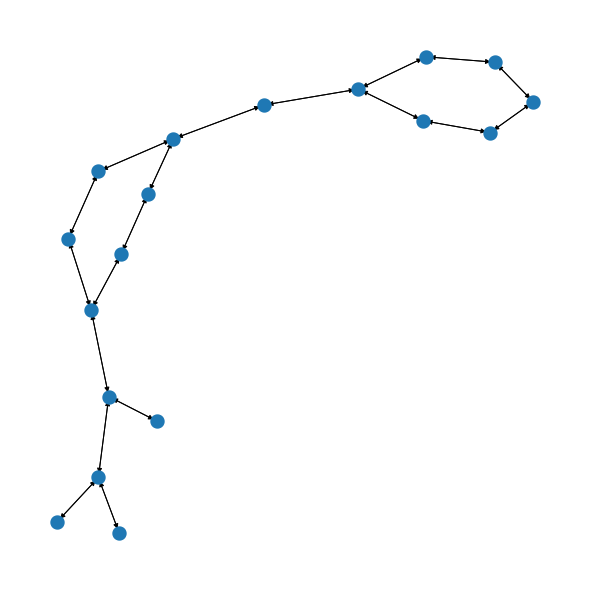

In [12]:
vis = to_networkx(graph)
plt.figure(1,figsize=(8,8)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_size=70,linewidths=6)
plt.show()

We can also plot the vertices attributes (a.k.a. the digits):

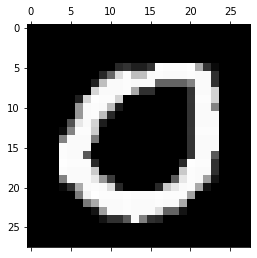

In [13]:
digit = x[5].reshape(28,28)
plt.matshow(digit, cmap='gray')

Let's now put the process above into the ```Dataset``` class of PyG. Specifically, we are going to create an ```InMemoryDataset```. From the official PyG documentation we see that some methods need to be override:

    torch_geometric.data.InMemoryDataset.raw_file_names(): A list of files in the raw_dir which needs to be found in order to skip the download.

    torch_geometric.data.InMemoryDataset.processed_file_names(): A list of files in the processed_dir which needs to be found in order to skip the processing.

    torch_geometric.data.InMemoryDataset.download(): Downloads raw data into raw_dir.

    torch_geometric.data.InMemoryDataset.process(): Processes raw data and saves it into the processed_dir.


In [14]:
import torch
import os
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from tqdm import tqdm


class Frankenstein(InMemoryDataset):
    
    # Base url to download the files
    url = 'http://nrvis.com/download/data/labeled/FRANKENSTEIN.zip'
    
    def __init__(self, root, transform=None, pre_transform=None):
        super(Frankenstein, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # List of the raw files
        return ['FRANKENSTEIN.edges', 'FRANKENSTEIN.graph_idx',
                'FRANKENSTEIN.graph_labels', 'FRANKENSTEIN.node_attrs']

    @property
    def processed_file_names(self):
        return 'data.pt'

    def download(self):
        # Download the file specified in self.url and store
        # it in self.raw_dir
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        # The zip file is removed
        os.unlink(path)


    def process(self):
        # Read the files' content as Pandas DataFrame. Nodes and graphs ids
        # are based on the file row-index, we adjust the DataFrames indices
        # by starting from 1 instead of 0.
        
        path = os.path.join(self.raw_dir, 'FRANKENSTEIN.node_attrs')
        node_attrs = pd.read_csv(path, sep=',', header=None)
        node_attrs.index += 1
        
        path = os.path.join(self.raw_dir, 'FRANKENSTEIN.edges')
        edge_index = pd.read_csv(path, sep=',', names=['source', 'target'])
        edge_index.index += 1
        
        path = os.path.join(self.raw_dir, 'FRANKENSTEIN.graph_idx')
        graph_idx = pd.read_csv(path, sep=',', names=['idx'])
        graph_idx.index += 1
        
        path = os.path.join(self.raw_dir, 'FRANKENSTEIN.graph_labels')
        graph_labels = pd.read_csv(path, sep=',', names=['label'])
        graph_labels.index += 1
        
        
        # In the loop we extract the nodes' embeddings, edges connectivity for 
        # and label for a graph, process the information and put it in a Data
        # object, then we add the object to a list
        data_list = []
        ids_list = graph_idx['idx'].unique()
        for g_idx in tqdm(ids_list):
            node_ids = graph_idx.loc[graph_idx['idx']==g_idx].index
            
            # Node features
            attributes = node_attrs.loc[node_ids, :]
            
            # Edges info
            edges = edge_index.loc[edge_index['source'].isin(node_ids)]
            edges_ids = edges.index
            
            # Graph label
            label = graph_labels.loc[g_idx]
            
            # Normalize the edges indices
            edge_idx = torch.tensor(edges.to_numpy().transpose(), dtype=torch.long)
            map_dict = {v.item():i for i,v in enumerate(torch.unique(edge_idx))}
            map_edge = torch.zeros_like(edge_idx)
            for k,v in map_dict.items():
                map_edge[edge_idx==k] = v
            
            # Convert the DataFrames into tensors 
            attrs = torch.tensor(attributes.to_numpy(), dtype=torch.float)
            pad = torch.zeros((attrs.shape[0], 4), dtype=torch.float)
            x = torch.cat((attrs, pad), dim=-1)

            edge_idx = map_edge.long()

            np_lab = label.to_numpy()
            y = torch.tensor(np_lab if np_lab[0] == 1 else [0], dtype=torch.long)
            
            graph = Data(x=x, edge_index=edge_idx,  y=y)
            
            data_list.append(graph)
            
        # Apply the functions specified in pre_filter and pre_transform
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        # Store the processed data
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])  

In [15]:
import torch_geometric.transforms as T

In [16]:
dataset = Frankenstein(root='data', pre_transform=T.GCNNorm())

### Open Graph Benchmark datasets

Open Graph Benchmark is available as a python library, to install it just run

```pip install ogb```

OGB allows to load a dataset in three ways: for PyG applications, for DGL (Deep Graph Library, another widely used tool for GNNs in python) and in an 'agnostic' manner. There is a naming convention to load a dataset, depending on the task an the dataset name:

    ogbn-[name]: for node tasks
    ogbg-[name]: for graph tasks
    ogbl-[name]: for link tasks

In [17]:
from ogb.nodeproppred import PygNodePropPredDataset
#from ogb.graphproppred import PygGraphPropPredDataset
#from ogb.linkproppred import PygLinkPropPredDataset

In [18]:
dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name = dataset_name, root='data') 

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
graph = dataset[0] 

In [19]:
graph

Data(num_nodes=169343, edge_index=[2, 1166243], x=[169343, 128], node_year=[169343, 1], y=[169343, 1])

### Benchmarking Graph Neural Networks Datasets

In [20]:
import torch_geometric.datasets as datasets

datasets.__all__

['KarateClub',
 'TUDataset',
 'GNNBenchmarkDataset',
 'Planetoid',
 'FakeDataset',
 'FakeHeteroDataset',
 'NELL',
 'CitationFull',
 'CoraFull',
 'Coauthor',
 'Amazon',
 'PPI',
 'Reddit',
 'Reddit2',
 'Flickr',
 'Yelp',
 'AmazonProducts',
 'QM7b',
 'QM9',
 'MD17',
 'ZINC',
 'AQSOL',
 'MoleculeNet',
 'Entities',
 'RelLinkPredDataset',
 'GEDDataset',
 'AttributedGraphDataset',
 'MNISTSuperpixels',
 'FAUST',
 'DynamicFAUST',
 'ShapeNet',
 'ModelNet',
 'CoMA',
 'SHREC2016',
 'TOSCA',
 'PCPNetDataset',
 'S3DIS',
 'GeometricShapes',
 'BitcoinOTC',
 'ICEWS18',
 'GDELT',
 'DBP15K',
 'WILLOWObjectClass',
 'PascalVOCKeypoints',
 'PascalPF',
 'SNAPDataset',
 'SuiteSparseMatrixCollection',
 'AMiner',
 'WordNet18',
 'WordNet18RR',
 'WikiCS',
 'WebKB',
 'WikipediaNetwork',
 'Actor',
 'OGB_MAG',
 'DBLP',
 'MovieLens',
 'IMDB',
 'LastFM',
 'HGBDataset',
 'JODIEDataset',
 'MixHopSyntheticDataset',
 'UPFD',
 'GitHub',
 'FacebookPagePage',
 'LastFMAsia',
 'DeezerEurope',
 'GemsecDeezer',
 'Twitch',
 'Airp

In [21]:
datasets.GNNBenchmarkDataset.names

['PATTERN', 'CLUSTER', 'MNIST', 'CIFAR10', 'TSP', 'CSL']

In [22]:
dataset = datasets.GNNBenchmarkDataset(name='MNIST', root='data')

In [23]:
dataset

MNIST(55000)